# Optimization of a simple phosphorus cycling model

> **Warning!**
> This example is not finished yet.
> It lacks a number of things, including explanatory text, references, and more.
> However, it can already serve as an example of model optimization.

## Tracer equations

We consider a simple model for the cycling of phosphorus with 2 state variables consisting of phosphate (PO₄) AKA dissolved inorganic phosphorus (DIP) and particulate organic phosphorus (POP).
The dissolved phases are transported by advection and diffusion whereas the particulate phase sinks rapidly down the water column without any appreciable transport by the circulation.

The governing equations that couple the 3D concentration fields of DIP and POP, denoted $x_\mathsf{DIP}$ and $x_\mathsf{POP}$, respectively, are:

$$\left[\frac{\partial}{\partial t} + \nabla \cdot (\boldsymbol{u} + \mathbf{K}\cdot\nabla )\right] x_\mathsf{DIP} = -U(x_\mathsf{DIP}) + R(x_\mathsf{POP}),$$

and

$$\left[\frac{\partial}{\partial t} + \nabla \cdot \boldsymbol{w}\right] x_\mathsf{POP} = U(x_\mathsf{DIP}) - R(x_\mathsf{POP}).$$

The 3D vector $\boldsymbol{u}$ is the fluid velocity and $\mathbf{K}$ is the eddy-diffusion tensor.
Thus, $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$ is a differential operator that represents the transport by the ocean circulation.
The 3D vector $\boldsymbol{w}$ is the particulate sinking velocity, so that the operator $\nabla \cdot \boldsymbol{w}$ acting on $x_\mathsf{POP}$ is the divergence of the flux of POP.
We will assume that it increases linearly with depth, i.e., that

$$\boldsymbol{w}(\boldsymbol{r}) = \boldsymbol{w}_0 + \boldsymbol{w}' z,$$

where $\boldsymbol{w}_0$ and $\boldsymbol{w}'$ are simple scalars, independent of location $\boldsymbol{r}$.
($z$ represents the depth of location $\boldsymbol{r}=(x,y,z)$.)

The function $U$ represents the biological uptake of DIP by phytoplankton, which we model as

$$U(x_\mathsf{DIP}) = \frac{x_\mathsf{DIP}}{\tau} \, \frac{x_\mathsf{DIP}}{x_\mathsf{DIP} + k} \, (z < z_0),$$

where the timescale, $\tau$, sets the maximum specific DIP uptake rate.
The first term in the product scales linearly with DIP, which is a nice property to have in general.
It also makes it easier to reason about the extreme cases.
However, here the uptake is not linear:
the second term in the product is a hyperbolic term (after Monod or Michaelis-Menten) and reduces the slope of the uptake function when DIP is low.
When DIP is very low, the slope is close to 0.
But when DIP is very high, the slope is close to $1/τ$.
The last term is to be understood as a condition, i.e., that the uptake happens only in the euphotic layer, where there is sufficient light for photosynthesis to occur.
The depth $z_0$ is the depth of the euphotic layer.

The function $R$ defines the remineralization rate of POP, which converts POP back into DIP.
For the remineralization, we simply use a linear rate constant, i.e.,

$$R(x_\mathsf{POP}) = \kappa \, x_\mathsf{POP}.$$

## Translation into AIBECS code

### Transport matrices

We start by telling Julia we want to use the AIBECS

In [1]:
using AIBECS

We load the circulation and grid of the OCIM0.1 via

In [2]:
wet3D, grd, T_OCIM = OCIM0.load() ;

Loading OCIM0.1  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0    235      0 --:--:-- --:--:-- --:--:--   235
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 44.9M  100 44.9M    0     0   9.9M      0  0:00:04  0:00:04 --:--:-- 15.7M
 ✔
┌ Info: You are about to use OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the r

where the operator $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \cdot \nabla \right]$ is represented by the sparse matrix `T_OCIM`.
In AIBECS, all the transport matrices must be declared as functions of the parameters `p`, so we simply define

In [3]:
T_DIP(p) = T_OCIM

T_DIP (generic function with 1 method)

For the sinking of particles, we are going to create a sparse matrix that depends on the parameters, too, which define how fast particles sink.

In [4]:
T_POP(p) = buildPFD(grd, wet3D, sinking_speed = w(p))

T_POP (generic function with 1 method)

for which we need to define the sinking speed `w(p)` as a function of the parameters `p`.
Following the assumption that it increases linearly with depth, we write it as

In [5]:
w(p) = p.w₀ .+ p.w′ * z

w (generic function with 1 method)

For this to work, we must create a vector of depths, `z`, which is simply done via

In [6]:
iwet = findall(wet3D)
z = ustrip.(grd.depth_3D[iwet])

191169-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮              
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

(We must strip the units via `ustrip` because units do not percolate through the functionality of AIBECS flawlessly at this early stage of development.)
We combine the transport operators for DIP and POP into a single tuple via

In [7]:
T_all = (T_DIP, T_POP) ;

### Local sources and sinks

##### Geological Restoring

Because AIBECS will solve for the steady state solution directly without time-stepping the goverining equations to equilibrium, we don't have any opportunity to specify any intial conditions.
Initial conditions are how the total amount of conserved elements get specified in most global biogeochemical modelels.
Thus to specify the total inventory of P in AIBECS we add a very weak resporing term to, e.g., the DIP equation.
The time-scale for this restoring term is chosen to be very long compared to the timescale with which the ocean circulation homogenizes a tracer.
Because of this long timescale we call it the geological restoring term, but geochemists who work on geological processes don't like that name!
In any event the long timescale allows us to prescribe the total inventory of P in a way that yields the same solution we would have gotten had we time-stepped the model to steady-state with the total inventory prescribed by the initial condition.
We define the geological restoring simply as

In [8]:
geores(x, p) = (p.DIPgeo .- x) / p.τgeo

geores (generic function with 1 method)

##### Uptake (DIP → POP)

For the phosphate uptake, we must take some precautions to avoid the pole of the hyperbolic term.
That is, we ensure that uptake only occurs when DIP is positive via the `relu` function

In [9]:
relu(x) = (x .≥ 0) .* x

relu (generic function with 1 method)

Then we simply write the uptake as a Julia function, following the definition of $U$:

In [10]:
function uptake(DIP, p)
    τ, k, z₀ = p.τ, p.k, p.z₀
    DIP⁺ = relu(DIP)
    return 1/τ * DIP⁺.^2 ./ (DIP⁺ .+ k) .* (z .≤ z₀)
end

uptake (generic function with 1 method)

where we have "unpacked" the parameters to make the code clearer and as close to the mathematical equation as possible.

##### Remineralization (POP → DIP)

In [11]:
remineralization(POP, p) = p.κ * POP

remineralization (generic function with 1 method)

##### Net sources and sinks

We lump the sources and sinks into `sms` functions (for Sources Minus Sinks):

In [12]:
function sms_DIP(DIP, POP, p)
    return -uptake(DIP, p) + remineralization(POP, p) + geores(DIP, p)
end
function sms_POP(DIP, POP, p)
    return  uptake(DIP, p) - remineralization(POP, p)
end

sms_POP (generic function with 1 method)

and create a tuple of those just like for the transport matrices via

In [13]:
sms_all = (sms_DIP, sms_POP) # bundles all the source-sink functions in a tuple

(Main.##363.sms_DIP, Main.##363.sms_POP)

For the sake of this notebook, however, we write more efficient BGC functions for the sources and sinks by using "in place" functions that mutate a preallocated vector to avoid allocations.
`G_DIP!` replaces `sms_DIP`:

In [14]:
function G_DIP!(dDIP, DIP, POP, p)
    τ, k, z₀, κ, DIPgeo, τgeo = p.τ, p.k, p.z₀, p.κ, p.DIPgeo, p.τgeo
    dDIP .= @. -(DIP ≥ 0) / τ * DIP^2 / (DIP + k) * (z ≤ z₀) + κ * POP + (DIPgeo - DIP) / τgeo
    return dDIP
end

G_DIP! (generic function with 1 method)

Note the use of the `@.` macro to "fuse" the loops together, which is faster than looping for each operation.
And `G_POP!` replaces `sms_POP`:

In [15]:
function G_POP!(dPOP, DIP, POP, p)
    τ, k, z₀, κ = p.τ, p.k, p.z₀, p.κ
    dPOP .= @. (DIP ≥ 0) / τ * DIP^2 / (DIP + k) * (z ≤ z₀) - κ * POP
    return dPOP
end

G_POP! (generic function with 1 method)

which we bundle into

In [16]:
Gs = (G_DIP!, G_POP!)

(Main.##363.G_DIP!, Main.##363.G_POP!)

### Parameters

We now define and build the parameters.
In AIBECS, this is done by first creating a table of parameters, using the API designed for it.
First, we create an empty table:

In [17]:
t = empty_parameter_table()    # empty table of parameters

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String


Then, we add every parameter that we need

In [18]:
add_parameter!(t, :DIPgeo, 2.12u"mmol/m^3",
               optimizable = true,
               variance_obs = ustrip(upreferred(0.1 * 2.17u"mmol/m^3"))^2,
               description = "Mean PO₄ concentration")
add_parameter!(t, :τgeo, 1.0u"Myr",
               description = "Geological restoring timescale")
add_parameter!(t, :k, 6.62u"μmol/m^3",
               optimizable = true,
               description = "Half-saturation constant (Michaelis-Menten)")
add_parameter!(t, :z₀, 80.0u"m",
               description = "Depth of the euphotic layer base")
add_parameter!(t, :w₀, 0.64u"m/d",
               optimizable = true,
               description = "Sinking velocity at surface")
add_parameter!(t, :w′, 0.13u"1/d",
               optimizable = true,
               description = "Vertical gradient of sinking velocity")
add_parameter!(t, :κ, 0.19u"1/d",
               optimizable = true,
               description = "Remineralization rate constant (POP to DIP)")
add_parameter!(t, :τ, 236.52u"d",
               optimizable = true,
               description = "Maximum uptake rate timescale")

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool
1,DIPgeo,0.00212,mol m^-3,mmol m^-3,0.00212,4.7089e-8,true
2,τgeo,3.15576e13,s,Myr,NaN,NaN,false
3,k,6.62e-6,mol m^-3,μmol m^-3,6.62e-6,4.38244e-11,true
4,z₀,80.0,m,m,NaN,NaN,false
5,w₀,7.40741e-6,m s^-1,m d^-1,7.40741e-6,5.48697e-11,true
6,w′,1.50463e-6,s^-1,d^-1,1.50463e-6,2.26391e-12,true
7,κ,2.19907e-6,s^-1,d^-1,2.19907e-6,4.83593e-12,true
8,τ,2.04353e7,s,d,2.04353e7,4.17603e14,true


These values of these parameters have been optimized for the same model but embedded in the OCIM1 circulation and should yield a pretty good fit to observations.
However, because the circulation has changed from the OCIM1 to the OCIM0.1 used here, the best parameters have probably changed, too.
Thus, we will re-optimize these parameters below.
But first, we will just try to find the steady-state solution with these initial parameter values.

We generate a new type for the parameters, via

In [19]:
initialize_Parameters_type(t, "Pcycle_Parameters")   # Generate the parameter type

Finally, we can instantiate the parameter vector in a single line:

In [20]:
p = Pcycle_Parameters()

DIPgeo = 2.12e+00 [mmol m⁻³] 
  τgeo = 1.00e+00 [Myr] (fixed)
     k = 6.62e+00 [μmol m⁻³] 
    z₀ = 8.00e+01 [m] (fixed)
    w₀ = 6.40e-01 [m d⁻¹] 
    w′ = 1.30e-01 [d⁻¹] 
     κ = 1.90e-01 [d⁻¹] 
     τ = 2.37e+02 [d] 


where we have used the name of the new type that we created just earlier.

## Finding the steady-state solution

### Generate state function and Jacobian

We generate the in-place state function `F!` and its Jacobian in a single line
and the out-of-place `F` for use by the solver.
(Using `dx = similar(x)` creates a vector of the same type and size as `x` but without spending time copying its values, which is OK because we always fill the entire `dx` in calls to `g_DIP!` and G_POP!`.)

In [21]:
nb = length(iwet)
F!, ∇ₓF = inplace_state_function_and_Jacobian(T_all, Gs, nb)
F(x::Vector{Tx}, p::Pcycle_Parameters{Tp}) where {Tx,Tp} = F!(Vector{promote_type(Tx,Tp)}(undef,length(x)),x,p)

F (generic function with 1 method)

### Solve for the steady-state

We start from an initial guess,

In [22]:
x = p.DIPgeo * ones(2nb) # initial iterate

382338-element Array{Float64,1}:
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 ⋮                    
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004
 0.0021200000000000004

Create an instance of the steady-state problem

In [23]:
prob = SteadyStateProblem(F, ∇ₓF, x, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212  …  0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212, 0.00212]

and solve it

In [24]:
s = solve(prob, CTKAlg()).u

382338-element Array{Float64,1}:
 0.0020475554910165607
 0.002057421172117009 
 0.0017072134842503503
 0.001604394745303311 
 0.0014699843915421508
 0.0014133418232435521
 0.0013149985799484015
 0.0014421910936787152
 0.0013064467964472536
 0.0012054523290650314
 ⋮                    
 4.613921330187689e-9 
 2.672543832284385e-9 
 2.8666492055640978e-9
 4.854081489360668e-9 
 5.1262350724626185e-9
 4.906041130877634e-9 
 5.49232446806064e-9  
 5.310574580913026e-9 
 5.4657917053741616e-9

### Plotting

For plotting, we first unpack the state

In [25]:
DIP, POP = state_to_tracers(s, nb, 2)

([0.00204756, 0.00205742, 0.00170721, 0.00160439, 0.00146998, 0.00141334, 0.001315, 0.00144219, 0.00130645, 0.00120545  …  0.00135408, 0.00135561, 0.00132192, 0.00132191, 0.00223223, 0.00223441, 0.00222974, 0.00221617, 0.00222811, 0.00223251], [2.132e-5, 2.14231e-5, 1.77648e-5, 1.66908e-5, 1.52867e-5, 1.4695e-5, 1.36678e-5, 1.49964e-5, 1.35784e-5, 1.25235e-5  …  5.02825e-9, 4.61392e-9, 2.67254e-9, 2.86665e-9, 4.85408e-9, 5.12624e-9, 4.90604e-9, 5.49232e-9, 5.31057e-9, 5.46579e-9])

We will plot the concentration of DIP at a given depth horizon

In [26]:
iz = findfirst(grd.depth .> 2000u"m")
iz, grd.depth[iz]

(17, 2141.005498821681 m)

In [27]:
DIP_3D = rearrange_into_3Darray(DIP, wet3D)
DIP_2D = DIP_3D[:,:,iz] * ustrip(1.0u"mol/m^3" |> u"mmol/m^3")
lat, lon = ustrip.(grd.lat), ustrip.(grd.lon)

([-89.0, -87.0, -85.0, -83.0, -81.0, -79.0, -77.0, -75.0, -73.0, -71.0  …  71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0  …  341.0, 343.0, 345.0, 347.0, 349.0, 351.0, 353.0, 355.0, 357.0, 359.0])

Create the Cartopy canvas, make the data cyclic in order for the plot to look good in Cartopy, and plot the filled contour via `contourf`

┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot /home/travis/.julia/packages/PyPlot/cdCMF/src/init.jl:155


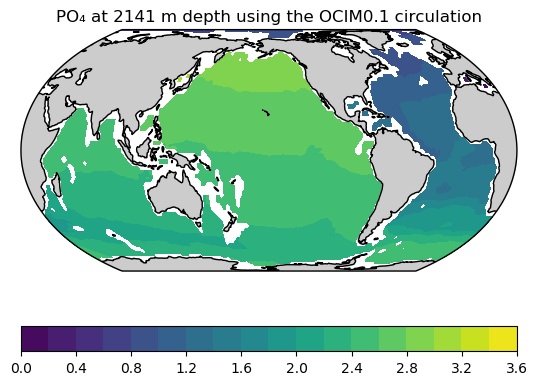

In [28]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall
clf()
ccrs = pyimport("cartopy.crs")
cfeature = pyimport("cartopy.feature")
ax = subplot(projection = ccrs.EqualEarth(central_longitude=-155.0))
ax.add_feature(cfeature.COASTLINE, edgecolor="#000000") # black coast lines
ax.add_feature(cfeature.LAND, facecolor="#CCCCCC")      # gray land
lon_cyc = [lon; 360+lon[1]]
DIP_2D_cyc = hcat(DIP_2D, DIP_2D[:,1])
plt = contourf(lon_cyc, lat, DIP_2D_cyc, levels=0:0.2:3.6, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(plt, orientation="horizontal");
title("PO₄ at $(string(round(typeof(1u"m"),grd.depth[iz]))) depth using the OCIM0.1 circulation")
gcf()

## Optimizing the model parameters

To optimize the model, we will use data from the World Ocean Atlas (WOA).
Specifically, we will use the observed PO<sub>4</sub> climatology, which the WOA produces every few years.
Thanks to the [WorldOceanAtlasTools](https://github.com/briochemc/WorldOceanAtlasTools.jl) package combined with some AIBECS functionality, this is done a just a few commands:

In [29]:
using WorldOceanAtlasTools
μDIPobs3D, σ²DIPobs3D = WorldOceanAtlasTools.fit_to_grid(grd, 2018, "phosphate", "annual", "1°", "an")
μDIPobs, σ²DIPobs = μDIPobs3D[iwet], σ²DIPobs3D[iwet]
μx = (μDIPobs, missing)
σ²x = (σ²DIPobs, missing)

Registering WOA data with DataDeps
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  176M  100  176M    0     0  41.4M      0  0:00:04  0:00:04 --:--:-- 41.4M
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 6a121a086bf36c5ea44773f63c8b7626614b024f0397cd0fc4d58150759a2d2c
└ @ DataDeps /home/travis/.julia/packages/DataDeps/RYAia/src/verification.jl:44
  Reading NetCDF file
  Rearranging data
  Filtering data
  Averaging data over each grid box
  Setting μ = 0 and σ² = ∞ where no obs
  Setting a realistic minimum for σ²


([Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], missing)

We define some hyper parameters for the weight of the mismatch of DIP, POP, and the parameters with observations / their prior estimates.

In [30]:
ωs = [1.0, 0.0] # the weight for the mismatch (weight of POP = 0)
ωp = 1e-4       # the weight for the parameters prior estimates

0.0001

We then generate the objective function and some derivatives using the PO₄ mean and variance

In [31]:
v = ustrip.(vector_of_volumes(wet3D, grd))
f   =   generate_objective(ωs, μx, σ²x, v, ωp, mean_obs(p), variance_obs(p))
∇ₓf = generate_∇ₓobjective(ωs, μx, σ²x, v, ωp, mean_obs(p), variance_obs(p))
∇ₚf = generate_∇ₚobjective(ωs, μx, σ²x, v, ωp, mean_obs(p), variance_obs(p))

(::getfield(AIBECS, Symbol("#∇ₚf#84")){Float64,Array{Float64,1},Array{Float64,1}}) (generic function with 1 method)

For the optimization, we will use the F-1 algorithm from the [F1Method](https://github.com/briochemc/F1Method.jl) package.

In [32]:
using F1Method

For the F-1 algorithm, we must initialize the memory buffer

In [33]:
mem = F1Method.initialize_mem(s, p)

F1Method.Mem([0.00204756, 0.00205742, 0.00170721, 0.00160439, 0.00146998, 0.00141334, 0.001315, 0.00144219, 0.00130645, 0.00120545  …  5.02825e-9, 4.61392e-9, 2.67254e-9, 2.86665e-9, 4.85408e-9, 5.12624e-9, 4.90604e-9, 5.49232e-9, 5.31057e-9, 5.46579e-9], nothing, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0], nothing)

We then define the objective, gradient, and Hessian using the F1Method package API

In [34]:
objective(p) = F1Method.objective(f, F, ∇ₓF, mem, p, CTKAlg())
gradient(p) = F1Method.gradient(f, F, ∇ₓf, ∇ₓF, mem, p, CTKAlg())
hessian(p) = F1Method.hessian(f, F, ∇ₓf, ∇ₓF, mem, p, CTKAlg())

hessian (generic function with 1 method)

Because we want the parameters to remain positive, we define the change of variables
The change variable from vector `λ = log(p)` to Parameters `p`:

In [35]:
λ2p(λ) = AIBECS.opt_para(exp.(λ))

λ2p (generic function with 1 method)

and the corresponding derivatives:

In [36]:
∇λ2p(λ) = exp.(λ)
∇²λ2p(λ) = exp.(λ)

∇²λ2p (generic function with 1 method)

Reverse change of variables from Parameters p to vector λ

In [37]:
p2λ(p) = log.(optvec(p))
λ = p2λ(p)

obj(λ) = objective(λ2p(λ))
using LinearAlgebra
grad(λ) = gradient(λ2p(λ)) * Diagonal(∇λ2p(λ))
function hess(λ)
    ∇p = Diagonal(∇λ2p(λ)) # for variable change
    ∇²p = Diagonal(∇²λ2p(λ)) # for variable change
    G = vec(gradient(λ2p(λ)))
    H = hessian(λ2p(λ))
    return ∇p * H * ∇p + Diagonal(G) * ∇²p
end

hess (generic function with 1 method)

Use optim to optimize

In [38]:
using Optim

Add storage for use with Optim

In [39]:
m = length(p)
grad(s, λ) = s[1:m] .= vec(grad(λ))
hess(s, λ) = s[1:m,1:m] .= hess(λ)

hess (generic function with 2 methods)

Set options of Optim

In [40]:
opt = Optim.Options(store_trace = false, show_trace = true, extended_trace = false)

                x_abstol = 0.0
                x_reltol = 0.0
                f_abstol = 0.0
                f_reltol = 0.0
                g_abstol = 1.0e-8
                g_reltol = 1.0e-8
          outer_x_abstol = 0.0
          outer_x_reltol = 0.0
          outer_f_abstol = 0.0
          outer_f_reltol = 0.0
          outer_g_abstol = 1.0e-8
          outer_g_reltol = 1.0e-8
           f_calls_limit = 0
           g_calls_limit = 0
           h_calls_limit = 0
       allow_f_increases = false
 allow_outer_f_increases = false
        successive_f_tol = 0
              iterations = 1000
        outer_iterations = 1000
             store_trace = false
           trace_simplex = false
              show_trace = true
          extended_trace = false
              show_every = 1
                callback = nothing
              time_limit = NaN


The starting parameters are

In [41]:
p

DIPgeo = 2.12e+00 [mmol m⁻³] 
  τgeo = 1.00e+00 [Myr] (fixed)
     k = 6.62e+00 [μmol m⁻³] 
    z₀ = 8.00e+01 [m] (fixed)
    w₀ = 6.40e-01 [m d⁻¹] 
    w′ = 1.30e-01 [d⁻¹] 
     κ = 1.90e-01 [d⁻¹] 
     τ = 2.37e+02 [d] 


Run optimization

In [42]:
results = optimize(obj, grad, hess, λ, NewtonTrustRegion(), opt)

Iter     Function value   Gradient norm 
     0     8.891144e-01     2.617999e+00
 * time: 0.003384113311767578
     1     2.366378e-01     7.203059e-01
 * time: 77.71845412254333
     2     6.826628e-02     5.222641e-02
 * time: 148.4319941997528
     3     6.562008e-02     9.678785e-03
 * time: 217.32488203048706
     4     6.531636e-02     9.022990e-04
 * time: 285.7519152164459
     5     6.528552e-02     1.354770e-04
 * time: 353.41192412376404
     6     6.528476e-02     3.830416e-06
 * time: 419.56561613082886
     7     6.528476e-02     3.161850e-09
 * time: 463.1286561489105


 * Status: success

 * Candidate solution
    Minimizer: [-6.86e+00, -1.23e+01, -1.26e+01,  ...]
    Minimum:   6.528476e-02

 * Found with
    Algorithm:     Newton's Method (Trust Region)
    Initial Point: [-6.16e+00, -1.19e+01, -1.18e+01,  ...]

 * Convergence measures
    |x - x'|               = 6.51e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.46e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.01e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.21e-09 ≰ 0.0e+00
    |g(x)|                 = 3.16e-09 ≤ 1.0e-08

 * Work counters
    Iterations:    7
    f(x) calls:    8
    ∇f(x) calls:   8
    ∇²f(x) calls:  7


Because we started from an other optimized set of parameters, this should only take a few iterations.
The optimized parameters are

In [43]:
p_optimized = λ2p(results.minimizer)

DIPgeo = 1.05e+00 [mmol m⁻³] 
  τgeo = 1.00e+00 [Myr] (fixed)
     k = 4.73e+00 [μmol m⁻³] 
    z₀ = 8.00e+01 [m] (fixed)
    w₀ = 2.84e-01 [m d⁻¹] 
    w′ = 1.36e-02 [d⁻¹] 
     κ = 1.45e+00 [d⁻¹] 
     τ = 1.72e+03 [d] 


After optimizing these parameters, we expect the fit to be better.
Let's have a look at the optimized steady-state solution at the same depth as earlier, and compare it to the observed DIP field.
First, let's calculate the steady-state with the optimized parameters.

In [44]:
prob_optimized = SteadyStateProblem(F, ∇ₓF, s, p_optimized)
s_optimized = solve(prob_optimized, CTKAlg()).u

382338-element Array{Float64,1}:
 0.0010508373615618768
 0.0010516017224943934
 0.0010520126210484008
 0.0010515822393153927
 0.001051525290042897 
 0.0010517598921219128
 0.0010508262826376452
 0.0010506460079968997
 0.0010504486312245737
 0.0010497566713419133
 ⋮                    
 9.007078996152305e-36
 8.957819699533112e-36
 8.975081374965901e-36
 8.972071729567476e-36
 8.972290119892289e-36
 8.96974417289356e-36 
 8.986706032204937e-36
 8.973999068798504e-36
 8.980302932177703e-36

Like earlier, we fill in a 3D array of `NaN`s with the values we want to plot.
Here, we fill the arrays with the fractional difference bewteen modeled and observed DIP:

In [45]:
DIPold, _ = state_to_tracers(s, nb, 2)
DIPnew, _ = state_to_tracers(s_optimized, nb, 2)
δDIPold_3D = fill(NaN, size(grd))
δDIPold_3D[iwet] .= 100(DIPold - μDIPobs) ./ μDIPobs
δDIPnew_3D = fill(NaN, size(grd))
δDIPnew_3D[iwet] .= 100(DIPnew - μDIPobs) ./ μDIPobs

191169-element view(::Array{Float64,3}, CartesianIndex{3}[CartesianIndex(11, 1, 1), CartesianIndex(12, 1, 1), CartesianIndex(13, 1, 1), CartesianIndex(14, 1, 1), CartesianIndex(15, 1, 1), CartesianIndex(16, 1, 1), CartesianIndex(17, 1, 1), CartesianIndex(18, 1, 1), CartesianIndex(19, 1, 1), CartesianIndex(20, 1, 1)  …  CartesianIndex(51, 166, 24), CartesianIndex(52, 166, 24), CartesianIndex(57, 166, 24), CartesianIndex(58, 166, 24), CartesianIndex(40, 167, 24), CartesianIndex(41, 167, 24), CartesianIndex(42, 167, 24), CartesianIndex(40, 168, 24), CartesianIndex(41, 168, 24), CartesianIndex(42, 168, 24)]) with eltype Float64:
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
   ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf

And take a slice at depth index `iz`

In [46]:
δDIPold_2D = δDIPold_3D[:,:,iz]
δDIPnew_2D = δDIPnew_3D[:,:,iz]

90×180 Array{Float64,2}:
 NaN       NaN       NaN       NaN       …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN       …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN  NaN
   ⋮                                     ⋱              ⋮                    
 -54.736   -58.211   -59.2839  -60.8372     NaN  NaN  Inf  Inf  Inf  Inf  Inf
 -55.1628  -58.5779  -59.1883  -60.729 

We make those 2D slices cyclic along the longitude for Cartopy

In [47]:
δDIPold_cyc = hcat(δDIPold_2D, δDIPold_2D[:,1])
δDIPnew_cyc = hcat(δDIPnew_2D, δDIPnew_2D[:,1])

90×181 Array{Float64,2}:
 NaN       NaN       NaN       NaN       …  NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN       …  NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
 NaN       NaN       NaN       NaN          NaN  NaN  NaN  NaN  NaN  NaN     
   ⋮                                     ⋱    ⋮                        ⋮     
 -54.736   -58.211   -59.2839  -60.8372     Inf  Inf  Inf  Inf  Inf  -54.736 
 -55.1628  -58.5779  -59.1883  -60.729 

And we plot the mismatch of the old, OCIM1-optimized field

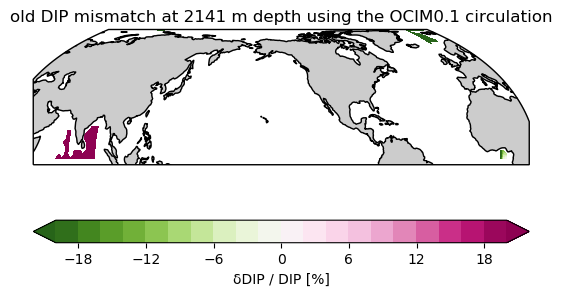

In [48]:
figure()
δDIPlevels = -20:2:20
ax = subplot(projection = ccrs.EqualEarth(central_longitude=-155.0))
ax.add_feature(cfeature.COASTLINE, edgecolor="#000000") # black coast lines
ax.add_feature(cfeature.LAND, facecolor="#CCCCCC")      # gray land
plt2 = contourf(lon_cyc, lat, δDIPold_cyc, cmap="PiYG_r", levels=δDIPlevels, transform=ccrs.PlateCarree(), zorder=-1, extend="both")
cbar2 = colorbar(plt2, orientation="horizontal", extend="both")
cbar2.set_label("δDIP / DIP [%]")
title("old DIP mismatch at $(string(round(typeof(1u"m"),grd.depth[iz]))) depth using the OCIM0.1 circulation")
gcf()

We can see a significant negative bias in the North Atlantic.
This is probably due to having swapped the circulation from OCIM1 to OCIM0.1.
Let's plot the OCIM-0.1-optimized mismatch

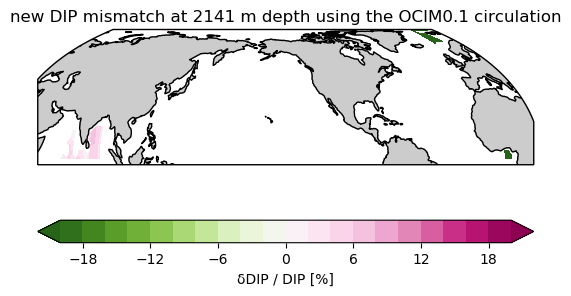

In [49]:
figure()
ax = subplot(projection = ccrs.EqualEarth(central_longitude=-155.0))
ax.add_feature(cfeature.COASTLINE, edgecolor="#000000") # black coast lines
ax.add_feature(cfeature.LAND, facecolor="#CCCCCC")      # gray land
plt3 = contourf(lon_cyc, lat, δDIPnew_cyc, cmap="PiYG_r", levels=δDIPlevels, transform=ccrs.PlateCarree(), zorder=-1, extend="both")
cbar3 = colorbar(plt3, orientation="horizontal", extend="both")
cbar3.set_label("δDIP / DIP [%]")
title("new DIP mismatch at $(string(round(typeof(1u"m"),grd.depth[iz]))) depth using the OCIM0.1 circulation")
gcf()

This shows that most of the negative bias has been corrected.
(The green patch in the North Atlantic has dissipated.)
Of course, this optimization was "easy", because there were only 2 tracers, few parameters, and we started from a pretty good solution.
However, this type of optimization can really improve the skill of models, even current "state-of-the-art" ones.
Such optimizations turn average models into better tools for cutting-edge oceanography research.

> **Note**
> If you find any bugs or ideas you want to test and struggle with the AIBECS, don't hesitate to raise issues on the GitHub [AIBECS](https://github.com/briochemc/AIBECS.jl) repository or [contact me](www.bpasquier.com)!

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*